<a href="https://colab.research.google.com/github/open-mmlab/mmpose/blob/main/demo/MMPose_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMPose Tutorial

Welcome to MMPose colab tutorial! In this tutorial, we will show you how to
- perform inference with an MMPose model
- train a new mmpose model with your own datasets

Let's start!

## Install MMPose

We recommend to use a conda environment to install mmpose and its dependencies. And compilers `nvcc` and `gcc` are required.

In [1]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/usr/local/bin/python


In [2]:
# install pytorch
!pip install torch

# install mmcv-full
!pip install mmcv-full

# install mmdet for inference demo
!pip install mmdet

# clone mmpose repo
!rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose

# install mmpose dependencies
!pip install -r requirements.txt

# install mmpose in develop mode
!pip install -e .

Cloning into 'mmpose'...
remote: Enumerating objects: 14284, done.
remote: Counting objects: 100% (5765/5765), done.
remote: Compressing objects: 100% (1703/1703), done.
remote: Total 14284 (delta 4749), reused 4309 (delta 4041), pack-reused 8519
Receiving objects: 100% (14284/14284), 22.11 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (9824/9824), done.
/content/mmpose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
  Cloning https://github.com/svenkreiss/poseval.git to /tmp/pip-install-8vxkdd34/poseval_86347c793f3645ad871b9eabc6f8b2fa
  Running command git clone -q https://github.com/svenkreiss/poseval.git /tmp/pip-install-8vxkdd34/poseval_86347c793f3645ad871b9eabc6f8b2fa
  Running command git submodule update --init --recursive -q
Obtaining file:///content/mmpose
  Running setup.py develop for mmpose


In [3]:
# Check Pytorch installation
import torch, torchvision
print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose
print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.9.0+cu111 True
torchvision version: 0.10.0+cu111
mmpose version: 0.19.0
cuda version: 11.1
compiler information: GCC 7.5


## Inference with an MMPose model

MMPose provides high level APIs for model inference and training.

Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth" to /root/.cache/torch/hub/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


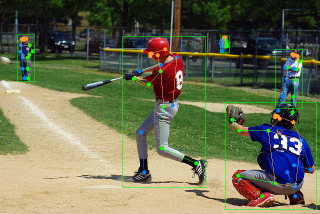

In [4]:
import cv2
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True

pose_config = 'configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w48_coco_256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

img = 'tests/data/coco/000000196141.jpg'

# inference detection
mmdet_results = inference_detector(det_model, img)

# extract person (COCO_ID=1) bounding boxes from the detection results
person_results = process_mmdet_results(mmdet_results, cat_id=1)

# inference pose
pose_results, returned_outputs = inference_top_down_pose_model(pose_model,
                                                               img,
                                                               person_results,
                                                               bbox_thr=0.3,
                                                               format='xyxy',
                                                               dataset=pose_model.cfg.data.test.type)

# show pose estimation results
vis_result = vis_pose_result(pose_model,
                             img,
                             pose_results,
                             dataset=pose_model.cfg.data.test.type,
                             show=False)
# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
  from IPython.display import Image, display
  import tempfile
  import os.path as osp
  with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result)
    display(Image(file_name))
else:
  cv2_imshow(vis_result)



## Train a pose estimation model on a customized dataset

To train a model on a customized dataset with MMPose, there are usually three steps:
1. Support the dataset in MMPose
1. Create a config
1. Perform training and evaluation

### Add a new dataset

There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. TopdownCOCODataset), as described in the [document](https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format). The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the demo dataset, which contains 100 samples (75 for training and 25 for validation) selected from COCO train2017 dataset. The annotations are stored in a different format from the original COCO format.



In [5]:
# download dataset
%mkdir data
%cd data
!wget https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmpose/datasets/coco_tiny.tar
!tar -xf coco_tiny.tar
%cd ..

/content/mmpose/data
--2021-10-22 05:14:35--  https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmpose/datasets/coco_tiny.tar
Resolving openmmlab.oss-cn-hangzhou.aliyuncs.com (openmmlab.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.174
Connecting to openmmlab.oss-cn-hangzhou.aliyuncs.com (openmmlab.oss-cn-hangzhou.aliyuncs.com)|118.31.232.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16558080 (16M) [application/x-tar]
Saving to: ‘coco_tiny.tar’

coco_tiny.tar       100%[===================>]  15.79M  2.27MB/s    in 14s     

2021-10-22 05:14:55 (1.16 MB/s) - ‘coco_tiny.tar’ saved [16558080/16558080]

/content/mmpose


In [6]:
# check the directory structure
!apt-get -q install tree
!tree data/coco_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (102 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
data/coco_tiny
├── images
│   ├── 000000012754.jpg
│   ├── 000000017741.jpg
│   ├── 000000019157.jpg
│   ├── 000000019523.jpg
│   ├── 000000019608.jpg
│   ├── 000000022816.jpg
│   ├── 000000031092.jpg
│   ├── 000000032124.jpg
│   ├── 000000037209.jpg
│   ├── 000000050713.jpg
│   ├── 0000000577

In [7]:
# check the annotation format
import json
import pprint

anns = json.load(open('data/coco_tiny/train.json'))

print(type(anns), len(anns))
pprint.pprint(anns[0], compact=True)


<class 'list'> 75
{'bbox': [267.03, 104.32, 229.19, 320],
 'image_file': '000000537548.jpg',
 'image_size': [640, 480],
 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 160, 2, 398,
               177, 2, 0, 0, 0, 437, 238, 2, 0, 0, 0, 477, 270, 2, 287, 255, 1,
               339, 267, 2, 0, 0, 0, 423, 314, 2, 0, 0, 0, 355, 367, 2]}


After downloading the data, we implement a new dataset class to load data samples for model training and validation. Assume that we are going to train a top-down pose estimation model (refer to [Top-down Pose Estimation](https://github.com/open-mmlab/mmpose/tree/master/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap#readme) for a brief introduction), the new dataset class inherits `TopDownBaseDataset`.

In [8]:
import json
import os
import os.path as osp
from collections import OrderedDict

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,
                                                  keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.base import Kpt2dSviewRgbImgTopDownDataset


@DATASETS.register_module()
class TopDownCOCOTinyDataset(Kpt2dSviewRgbImgTopDownDataset):

	def __init__(self,
				 ann_file,
				 img_prefix,
				 data_cfg,
				 pipeline,
				 dataset_info=None,
				 test_mode=False):
		super().__init__(
			ann_file, img_prefix, data_cfg, pipeline, dataset_info, coco_style=False, test_mode=test_mode)

		# flip_pairs, upper_body_ids and lower_body_ids will be used
		# in some data augmentations like random flip
		self.ann_info['flip_pairs'] = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10],
									   [11, 12], [13, 14], [15, 16]]
		self.ann_info['upper_body_ids'] = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
		self.ann_info['lower_body_ids'] = (11, 12, 13, 14, 15, 16)

		self.ann_info['joint_weights'] = None
		self.ann_info['use_different_joint_weights'] = False

		self.dataset_name = 'coco_tiny'
		self.db = self._get_db()

	def _get_db(self):
		with open(self.ann_file) as f:
			anns = json.load(f)

		db = []
		for idx, ann in enumerate(anns):
			# get image path
			image_file = osp.join(self.img_prefix, ann['image_file'])
			# get bbox
			bbox = ann['bbox']
			center, scale = self._xywh2cs(*bbox)
			# get keypoints
			keypoints = np.array(
				ann['keypoints'], dtype=np.float32).reshape(-1, 3)
			num_joints = keypoints.shape[0]
			joints_3d = np.zeros((num_joints, 3), dtype=np.float32)
			joints_3d[:, :2] = keypoints[:, :2]
			joints_3d_visible = np.zeros((num_joints, 3), dtype=np.float32)
			joints_3d_visible[:, :2] = np.minimum(1, keypoints[:, 2:3])

			sample = {
				'image_file': image_file,
				'center': center,
				'scale': scale,
				'bbox': bbox,
				'rotation': 0,
				'joints_3d': joints_3d,
				'joints_3d_visible': joints_3d_visible,
				'bbox_score': 1,
				'bbox_id': idx,
			}
			db.append(sample)

		return db

	def _xywh2cs(self, x, y, w, h):
		"""This encodes bbox(x, y, w, h) into (center, scale)
		Args:
			x, y, w, h
		Returns:
			tuple: A tuple containing center and scale.
			- center (np.ndarray[float32](2,)): center of the bbox (x, y).
			- scale (np.ndarray[float32](2,)): scale of the bbox w & h.
		"""
		aspect_ratio = self.ann_info['image_size'][0] / self.ann_info[
			'image_size'][1]
		center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)
		if w > aspect_ratio * h:
			h = w * 1.0 / aspect_ratio
		elif w < aspect_ratio * h:
			w = h * aspect_ratio

		# pixel std is 200.0
		scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
		# padding to include proper amount of context
		scale = scale * 1.25
		return center, scale

	def evaluate(self, outputs, res_folder, metric='PCK', **kwargs):
		"""Evaluate keypoint detection results. The pose prediction results will
		be saved in `${res_folder}/result_keypoints.json`.

		Note:
		batch_size: N
		num_keypoints: K
		heatmap height: H
		heatmap width: W

		Args:
		outputs (list(preds, boxes, image_path, output_heatmap))
			:preds (np.ndarray[N,K,3]): The first two dimensions are
				coordinates, score is the third dimension of the array.
			:boxes (np.ndarray[N,6]): [center[0], center[1], scale[0]
				, scale[1],area, score]
			:image_paths (list[str]): For example, ['Test/source/0.jpg']
			:output_heatmap (np.ndarray[N, K, H, W]): model outputs.

		res_folder (str): Path of directory to save the results.
		metric (str | list[str]): Metric to be performed.
			Options: 'PCK', 'NME'.

		Returns:
			dict: Evaluation results for evaluation metric.
		"""
		metrics = metric if isinstance(metric, list) else [metric]
		allowed_metrics = ['PCK', 'NME']
		for metric in metrics:
			if metric not in allowed_metrics:
				raise KeyError(f'metric {metric} is not supported')

		res_file = os.path.join(res_folder, 'result_keypoints.json')

		kpts = []
		for output in outputs:
			preds = output['preds']
			boxes = output['boxes']
			image_paths = output['image_paths']
			bbox_ids = output['bbox_ids']

			batch_size = len(image_paths)
			for i in range(batch_size):
				kpts.append({
					'keypoints': preds[i].tolist(),
					'center': boxes[i][0:2].tolist(),
					'scale': boxes[i][2:4].tolist(),
					'area': float(boxes[i][4]),
					'score': float(boxes[i][5]),
					'bbox_id': bbox_ids[i]
				})
		kpts = self._sort_and_unique_bboxes(kpts)

		self._write_keypoint_results(kpts, res_file)
		info_str = self._report_metric(res_file, metrics)
		name_value = OrderedDict(info_str)

		return name_value

	def _report_metric(self, res_file, metrics, pck_thr=0.3):
		"""Keypoint evaluation.

		Args:
		res_file (str): Json file stored prediction results.
		metrics (str | list[str]): Metric to be performed.
			Options: 'PCK', 'NME'.
		pck_thr (float): PCK threshold, default: 0.3.

		Returns:
		dict: Evaluation results for evaluation metric.
		"""
		info_str = []

		with open(res_file, 'r') as fin:
			preds = json.load(fin)
		assert len(preds) == len(self.db)

		outputs = []
		gts = []
		masks = []

		for pred, item in zip(preds, self.db):
			outputs.append(np.array(pred['keypoints'])[:, :-1])
			gts.append(np.array(item['joints_3d'])[:, :-1])
			masks.append((np.array(item['joints_3d_visible'])[:, 0]) > 0)

		outputs = np.array(outputs)
		gts = np.array(gts)
		masks = np.array(masks)

		normalize_factor = self._get_normalize_factor(gts)

		if 'PCK' in metrics:
			_, pck, _ = keypoint_pck_accuracy(outputs, gts, masks, pck_thr,
											  normalize_factor)
			info_str.append(('PCK', pck))

		if 'NME' in metrics:
			info_str.append(
				('NME', keypoint_nme(outputs, gts, masks, normalize_factor)))

		return info_str

	@staticmethod
	def _write_keypoint_results(keypoints, res_file):
		"""Write results into a json file."""

		with open(res_file, 'w') as f:
			json.dump(keypoints, f, sort_keys=True, indent=4)

	@staticmethod
	def _sort_and_unique_bboxes(kpts, key='bbox_id'):
		"""sort kpts and remove the repeated ones."""
		kpts = sorted(kpts, key=lambda x: x[key])
		num = len(kpts)
		for i in range(num - 1, 0, -1):
			if kpts[i][key] == kpts[i - 1][key]:
				del kpts[i]

		return kpts
	
	@staticmethod
	def _get_normalize_factor(gts):
		"""Get inter-ocular distance as the normalize factor, measured as the
		Euclidean distance between the outer corners of the eyes.

		Args:
			gts (np.ndarray[N, K, 2]): Groundtruth keypoint location.

		Return:
			np.ndarray[N, 2]: normalized factor
		"""

		interocular = np.linalg.norm(
			gts[:, 0, :] - gts[:, 1, :], axis=1, keepdims=True)
		return np.tile(interocular, [1, 2])



### Create a config file

In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at [Learn about Configs](https://mmpose.readthedocs.io/en/latest/tutorials/0_config.html). A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a HRNet on COCO dataset, and modify it to adapt to the COCOTiny dataset.

In [9]:
from mmcv import Config
cfg = Config.fromfile(
    './configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w32_coco_256x192.py'
)

# set basic configs
cfg.data_root = 'data/coco_tiny'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
cfg.gpu_ids = range(1)
cfg.seed = 0

# set log interval
cfg.log_config.interval = 1

# set evaluation configs
cfg.evaluation.interval = 10
cfg.evaluation.metric = 'PCK'
cfg.evaluation.save_best = 'PCK'

# set learning rate policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=10,
    warmup_ratio=0.001,
    step=[17, 35])
cfg.total_epochs = 40

# set batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)


# set dataset configs
cfg.data.train.type = 'TopDownCOCOTinyDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'TopDownCOCOTinyDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'TopDownCOCOTinyDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/val.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

print(cfg.pretty_text)


dataset_info = dict(
    dataset_name='coco',
    paper_info=dict(
        author=
        'Lin, Tsung-Yi and Maire, Michael and Belongie, Serge and Hays, James and Perona, Pietro and Ramanan, Deva and Doll{\'a}r, Piotr and Zitnick, C Lawrence',
        title='Microsoft coco: Common objects in context',
        container='European conference on computer vision',
        year='2014',
        homepage='http://cocodataset.org/'),
    keypoint_info=dict({
        0:
        dict(name='nose', id=0, color=[51, 153, 255], type='upper', swap=''),
        1:
        dict(
            name='left_eye',
            id=1,
            color=[51, 153, 255],
            type='upper',
            swap='right_eye'),
        2:
        dict(
            name='right_eye',
            id=2,
            color=[51, 153, 255],
            type='upper',
            swap='left_eye'),
        3:
        dict(
            name='left_ear',
            id=3,
            color=[51, 153, 255],
            type='upper

### Train and Evaluation


In [10]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build model
model = build_posenet(cfg.model)

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(
    model, datasets, cfg, distributed=False, validate=True, meta=dict())

Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w32-36af842e.pth


  0%|          | 0.00/126M [00:00<?, ?B/s]

2021-10-22 05:16:48,117 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 17.0 task/s, elapsed: 1s, ETA:     0s

2021-10-22 05:18:23,704 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_10.pth.
2021-10-22 05:18:23,706 - mmpose - INFO - Best PCK is 0.0840 at 10 epoch.
2021-10-22 05:18:23,712 - mmpose - INFO - Epoch(val) [10][2]	PCK: 0.0840
2021-10-22 05:18:27,661 - mmpose - INFO - Epoch [11][1/5]	lr: 5.045e-05, eta: 0:04:36, time: 3.935, data_time: 2.471, memory: 3354, mse_loss: 0.0019, acc_pose: 0.1373, loss: 0.0019
2021-10-22 05:18:29,025 - mmpose - INFO - Epoch [11][2/5]	lr: 5.145e-05, eta: 0:04:33, time: 1.364, data_time: 0.007, memory: 3354, mse_loss: 0.0014, acc_pose: 0.0752, loss: 0.0014
2021-10-22 05:18:30,391 - mmpose - INFO - Epoch [11][3/5]	lr: 5.245e-05, eta: 0:04:30, time: 1.366, data_time: 0.004, memory: 3354, mse_loss: 0.0020, acc_pose: 0.1156, loss: 0.0020
2021-10-22 05:18:31,753 - mmpose - INFO - Epoch [11][4/5]	lr: 5.345e-05, eta: 0:04:27, time: 1.362, data_time: 0.003, memory: 3354, mse_loss: 0.0022, acc_pose: 0.1821, loss: 0.0022
2021-10-22 05:18:32,873 - mmpose

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 17.4 task/s, elapsed: 1s, ETA:     0s

2021-10-22 05:19:59,135 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_20.pth.
2021-10-22 05:19:59,137 - mmpose - INFO - Best PCK is 0.1472 at 20 epoch.
2021-10-22 05:19:59,141 - mmpose - INFO - Epoch(val) [20][2]	PCK: 0.1472
2021-10-22 05:20:03,011 - mmpose - INFO - Epoch [21][1/5]	lr: 1.004e-04, eta: 0:03:01, time: 3.858, data_time: 2.399, memory: 3354, mse_loss: 0.0017, acc_pose: 0.3118, loss: 0.0017
2021-10-22 05:20:04,381 - mmpose - INFO - Epoch [21][2/5]	lr: 1.014e-04, eta: 0:02:59, time: 1.370, data_time: 0.006, memory: 3354, mse_loss: 0.0017, acc_pose: 0.3147, loss: 0.0017
2021-10-22 05:20:05,746 - mmpose - INFO - Epoch [21][3/5]	lr: 1.024e-04, eta: 0:02:57, time: 1.366, data_time: 0.003, memory: 3354, mse_loss: 0.0019, acc_pose: 0.3450, loss: 0.0019
2021-10-22 05:20:07,112 - mmpose - INFO - Epoch [21][4/5]	lr: 1.034e-04, eta: 0:02:54, time: 1.366, data_time: 0.005, memory: 3354, mse_loss: 0.0014, acc_pose: 0.3454, loss: 0.0014
2021-10-22 05:20:08,218 - mmpose

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 16.7 task/s, elapsed: 1s, ETA:     0s

2021-10-22 05:21:34,827 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_30.pth.
2021-10-22 05:21:34,829 - mmpose - INFO - Best PCK is 0.1623 at 30 epoch.
2021-10-22 05:21:34,832 - mmpose - INFO - Epoch(val) [30][2]	PCK: 0.1623
2021-10-22 05:21:38,825 - mmpose - INFO - Epoch [31][1/5]	lr: 1.504e-04, eta: 0:01:29, time: 3.971, data_time: 2.460, memory: 3354, mse_loss: 0.0015, acc_pose: 0.4097, loss: 0.0015
2021-10-22 05:21:40,197 - mmpose - INFO - Epoch [31][2/5]	lr: 1.513e-04, eta: 0:01:27, time: 1.372, data_time: 0.005, memory: 3354, mse_loss: 0.0014, acc_pose: 0.4815, loss: 0.0014
2021-10-22 05:21:41,566 - mmpose - INFO - Epoch [31][3/5]	lr: 1.523e-04, eta: 0:01:25, time: 1.369, data_time: 0.012, memory: 3354, mse_loss: 0.0011, acc_pose: 0.4479, loss: 0.0011
2021-10-22 05:21:42,925 - mmpose - INFO - Epoch [31][4/5]	lr: 1.533e-04, eta: 0:01:23, time: 1.359, data_time: 0.003, memory: 3354, mse_loss: 0.0014, acc_pose: 0.4278, loss: 0.0014
2021-10-22 05:21:44,044 - mmpose

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 16.9 task/s, elapsed: 1s, ETA:     0s

2021-10-22 05:23:10,466 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_40.pth.
2021-10-22 05:23:10,468 - mmpose - INFO - Best PCK is 0.1936 at 40 epoch.
2021-10-22 05:23:10,472 - mmpose - INFO - Epoch(val) [40][2]	PCK: 0.1936


Test the trained model. Since the model is trained on a toy dataset coco-tiny, its performance would be as good as the ones in our model zoo. Here we mainly show how to inference and visualize a local model checkpoint.

In [21]:
import pickle

file_output_save = '/content/poseestimation.model'

with open(file_output_save, 'wb') as file:
  pickle.dump(model, file)

In [19]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model, vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True

pose_checkpoint = 'work_dirs/hrnet_w32_coco_tiny_256x192/latest.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# initialize pose model
pose_model = init_pose_model(cfg, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

Use load_from_local loader


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_http loader


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


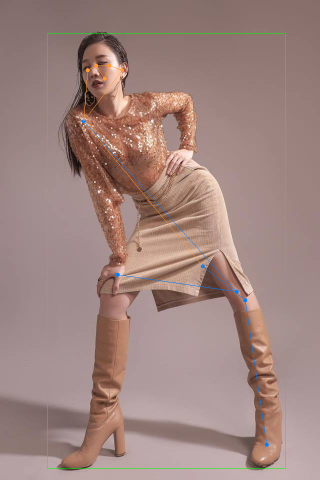

In [20]:
# add your path here
list_img = ['/content/test_1.png', '/content/test_2.jpg' , 'tests/data/coco/000000196141.jpg']

point_img = list_img[1]


# inference detection
mmdet_results = inference_detector(det_model, point_img)

# extract person (COCO_ID=1) bounding boxes from the detection results
person_results = process_mmdet_results(mmdet_results, cat_id=1)

# inference pose
pose_results, returned_outputs = inference_top_down_pose_model(pose_model, point_img, person_results, bbox_thr=0.3, format='xyxy', dataset='TopDownCocoDataset')

# show pose estimation results
vis_result = vis_pose_result(pose_model, point_img, pose_results, kpt_score_thr=0., dataset='TopDownCocoDataset', show=False)

# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

cv2_imshow(vis_result)